# Ultimate Take-Home Challenge
## Part 1: EDA of Logins

In [1]:
# Import modules and libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df_logins = pd.read_json('C:/Jupyter_Notebooks/ultimate_challenge/ultimate_challenge/logins.json')

In [3]:
df_logins.describe()

,login_time
count,93142
unique,92265
top,1970-02-12 11:16:53
freq,3
first,1970-01-01 20:12:16
last,1970-04-13 18:57:38


In [4]:
df_logins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
login_time    93142 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


Looking at the data, there are 93142 data points consisting of Timeseries data. Interestingly, there are only 92265 unique values, meaning that there are 877 copies of other data points.
<br> In order to show the data in 15 minute intervals, we will first aggregte the data, counting all the points that fall into those 15 minute slices. Following this, we will graph the points of the entire data set and see if there is any overall pattern in the data.

In [5]:
# Create counts of 15 min interval
fifteen = pd.Series(range(len(df_logins)), index = df_logins.login_time).resample('15Min').count()

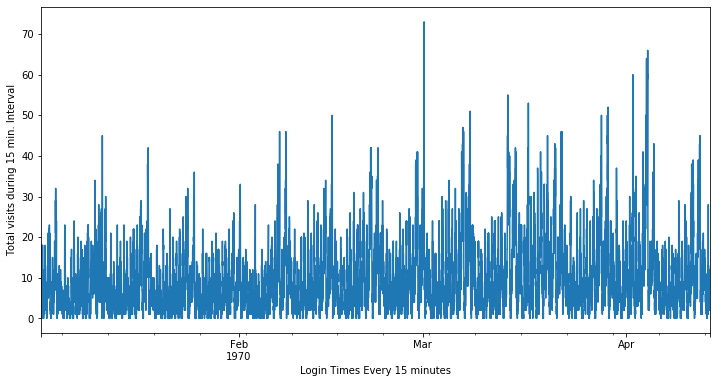

In [6]:
# Create plot og 15 min intervals for whole data
plt.subplots(figsize=(12,6))
fifteen.plot()
plt.xlabel("Login Times Every 15 minutes")
plt.ylabel("Total visits during 15 min. Interval")
plt.show()

From looking above, there does seem to be a pattern present in terms of peaks and valleys in the number of counts in the data. We can zoom into the data and see if the patterns is just on a monthly, weekly, or daily basis.

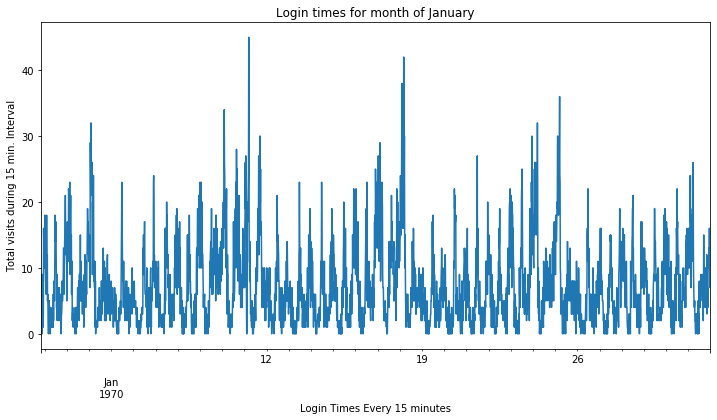

In [7]:
# Zoom into to 1 month of data
plt.subplots(figsize=(12,6))
fifteen['1970-01'].plot()
plt.xlabel("Login Times Every 15 minutes")
plt.ylabel("Total visits during 15 min. Interval")
plt.title("Login times for month of January")
plt.show()

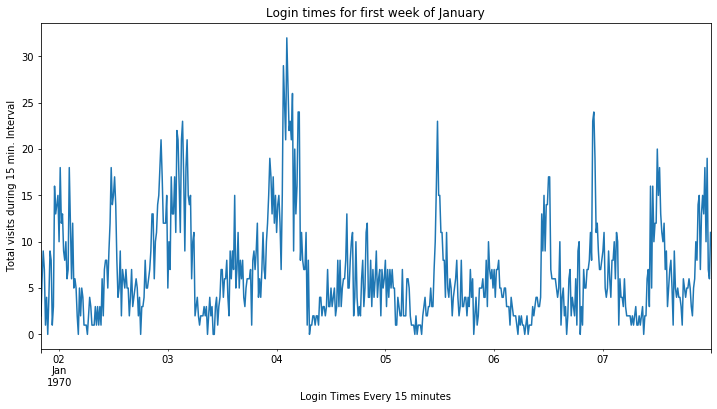

In [8]:
# Zoom into to 1 week of data
plt.subplots(figsize=(12,6))
fifteen['1970-01-01':'1970-01-07'].plot()
plt.xlabel("Login Times Every 15 minutes")
plt.ylabel("Total visits during 15 min. Interval")
plt.title("Login times for first week of January")
plt.show()

It seems the pattern of peaks and valleys are on a daily basis, forming during certain times during the day. We can consolidate the information from the entire dataset and see if there are peak login times during certain hours of the day. This can be done by adding all the values of the counts we have already acquired, and overlapping the hours to see which times have the fewest login counts and which have the most.

In [9]:
# overlapping daily data to observe trends of times per day.
fifteen_in_day = {}
for item in fifteen.index:
    if item.time() not in fifteen_in_day:
        fifteen_in_day[item.time()] = fifteen[item]
    else:
        fifteen_in_day[item.time()] += fifteen[item]


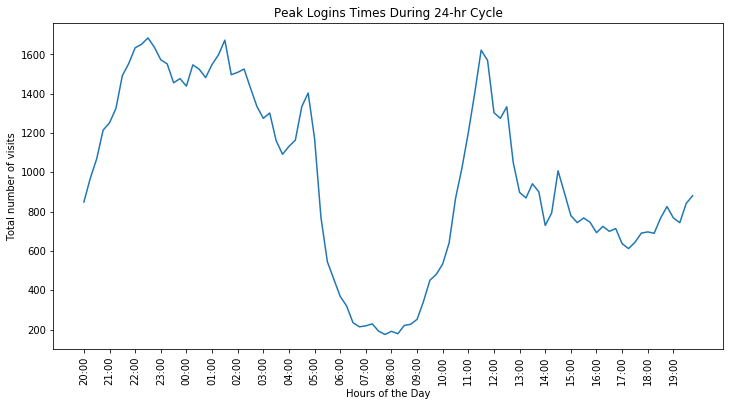

In [10]:
# Total visits during 4 months by time of day
time = list(map(lambda item : item.strftime('%H:%M'), fifteen_in_day.keys()))
counts = list(map(lambda item: item, fifteen_in_day.values()))

plt.subplots(figsize=(12,6))
plt.plot(time, counts)
plt.xticks(time[::4], rotation=90)
plt.xlabel("Hours of the Day")
plt.ylabel("Total number of visits")
plt.title("Peak Logins Times During 24-hr Cycle")
plt.show()

Looking above, it seems that peak times can be occur from 22:00 to maybe even 5:00 and 11-12. However, there seems to be a very obvious drop in activity from 6AM to 9AM.

In [11]:
# Total visits during 4 months by day of week
fifteen_weekday = {}
for item in fifteen.index:
    if item.weekday() not in fifteen_weekday:
        fifteen_weekday[item.weekday()] = fifteen[item]
    else:
        fifteen_weekday[item.weekday()] += fifteen[item]


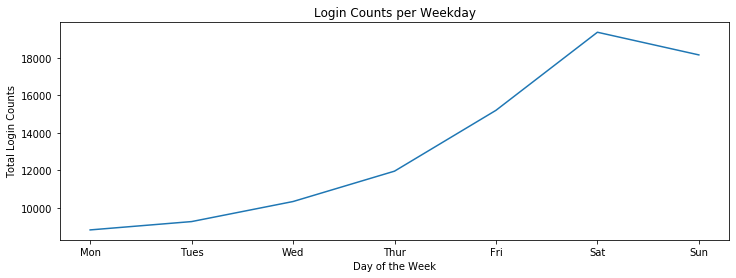

In [12]:
# Sorting weekdays day so monday-sunday
fifteen_weekday_sort = sorted(fifteen_weekday.items())

# Getting x and y points for plots
day_of_week = list(map(lambda item: item[0], fifteen_weekday_sort))
day_counts = list(map(lambda item: item[1], fifteen_weekday_sort))

# plot
plt.subplots(figsize=(12,4))
plt.plot(day_of_week, day_counts)
plt.xticks(np.arange(7),labels = ['Mon','Tues','Wed','Thur','Fri','Sat','Sun'])
plt.xlabel('Day of the Week')
plt.ylabel('Total Login Counts')
plt.title('Login Counts per Weekday')
plt.show()

Also, looking at the day of the week, it seems that the end of the week is more popular time to login than the beginning of the week.

## Part 2: Experiment and Metric Design

1. In the scenario given, two cities with different circadian rhythms (alternating between day and night) reside next two each other with a toll bridge between them. Because of the toll bridge, driver partners tend to stay exclusively to their own sides. However, the managers of city operations for both cities propose an experiment to encourage driver partners to be available in both cities by reimbursing all toll costs.

    A key metric for success would be an overall increase in toll activity. Since no other drivers should be affected by the experiment, an increase in toll activity would imply only driver partners using the toll bridge to cross it, since they would be reimbursed by it. This could even be further scrutinized by observing the activity on the Metropolis side of the toll during the day, when they are most active, and the Gotham side of the toll bridge during the night. Increased activity during either side’s entry onto the toll during their peak activity times would indicate success of the experiment.
    
    
2. 
    <br>a. Assuming there is already historical data of the tolls taken for the toll bridge in order to record typical daily activity, the next step would be two run a small promotional period for all driver partners, perhaps for 3 or 4 weeks. Then, this experimental month could be compared to historical months during the same time to see if there were significant differences in activity. Particularly, more daily activity on the Gotham side during the week in the experimental period would indicate more driver partners returning to Metropolis, and vice versa for Metropolis.

    b. Assuming a normal distribution of points and clean data, a student t-test to obtain the t-statistic comparing the mean of the experimental month against the means of the historical months of data.

    c. I would interpret the results to show if they were statistically significant in terms of difference between the means of the experimental month and the historical months. I would then explain that a caveat is that depending on the campaign of notifying the driver partners, it may take longer than a month to see a difference between the experiment’s timeframe and the historical timeframe.

## Part 3. Predictive Modeling

### 3a. Exploring, cleaning, and visualizing data

In [13]:
import json
from datetime import datetime, timedelta
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [14]:
# Open json file
with open('C:/Jupyter_Notebooks/ultimate_challenge/ultimate_challenge/ultimate_data_challenge.json') as file:
    data = json.load(file)

# Convert json to dataframe and give it variable
df_uc = pd.DataFrame(data)

In [15]:
df_uc.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [16]:
df_uc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [17]:
df_uc.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct
count,50000.000000,49799.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,5.796827,4.778158,4.601559,1.074764,8.849536,2.278200,60.926084
std,5.707357,0.446652,0.617338,0.222336,19.958811,3.792684,37.081503
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2.420000,4.700000,4.300000,1.000000,0.000000,0.000000,33.300000
50%,3.880000,5.000000,4.900000,1.000000,0.000000,1.000000,66.700000
75%,6.940000,5.000000,5.000000,1.050000,8.600000,3.000000,100.000000
max,160.960000,5.000000,5.000000,8.000000,100.000000,125.000000,100.000000


In [18]:
# Convert NaN values in avg_rating_by_driver to mean of data
df_uc.avg_rating_by_driver[df_uc.avg_rating_by_driver.isnull()] = df_uc.avg_rating_by_driver.mean()

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [19]:
# Convert NaN values in avg_rating_of_driver to mean of data
df_uc.avg_rating_of_driver[df_uc.avg_rating_of_driver.isnull()] = df_uc.avg_rating_of_driver.mean()

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [20]:
df_uc.loc[:,'phone'][df_uc.phone.isnull()] = 'None'

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


There was some missing data for the avg_rating_by_driver and avg_rating_of_driver columns. This was remedied by just by adding the means of the respective columns to the empty cells. This decision was reached by the fact that the 50 percentile of the data in the description of the dataframe seem to be higher than the mean of the data, so a few filled in should not throw off the data too much.
<br> The phone column also contained some empty values, so it was just filled in with the string “none” so at least to contain a string itself.

In [21]:
df_uc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     50000 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [22]:
# define a column counter to determine if there is a value or not in 
def column_counter(column):
    full = 0
    empty = 0
    for item in column:
        if item > 0:
            full += 1
        else:
            empty += 1
    return full, empty

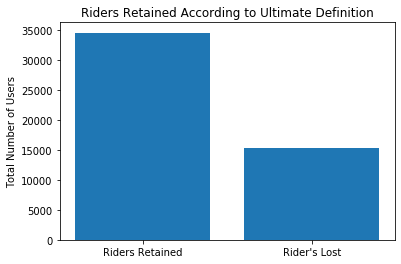

In [23]:
# plot bar graph of "retained rider" according to Ultimate

plt.bar(x = ['Riders Retained',"Rider's Lost"], height = column_counter(df_uc.trips_in_first_30_days))
plt.ylabel("Total Number of Users")
plt.title("Riders Retained According to Ultimate Definition")
plt.show()

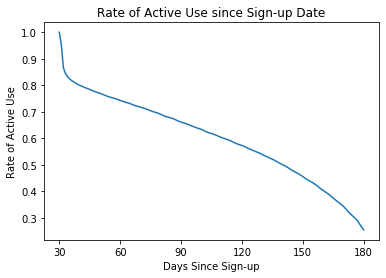

In [24]:
# Graph of drop off rate according to timeseries data of difference between signup_date and last_trip_date

# Convert dates in cells to Timeseries
df_uc.signup_date = pd.to_datetime(df_uc.signup_date)
df_uc.last_trip_date = pd.to_datetime(df_uc.last_trip_date)

# Find the total amount of days dataset could range from
total_length = df_uc.last_trip_date.max() - df_uc.signup_date.min()

# Create a value for each user that shows the drop-off rate by taking the difference of the signup and last_trip 
# dates, then dividing my the total length of the dataset. This will show how long a user is retained

active_days = df_uc.last_trip_date - df_uc.signup_date

active_rate = [(active_days >= timedelta(d-30)).mean() for d in range(181)]

# Graph of active rate, excluding those active in first 30 days
plt.plot(range(30, 181), active_rate[30:])
plt.xticks(range(30, 181)[::30])
plt.xlabel("Days Since Sign-up")
plt.ylabel("Rate of Active Use")
plt.title("Rate of Active Use since Sign-up Date")
plt.show()

After the first 30 days it seems that 80% of those who signed up in January are still using the service. Following this, about 30% of the users were still using the service by the time the data was pulled 181 days later.

In [25]:
# Cutoff date for retained users
cutoff_date = df_uc.last_trip_date.max()-timedelta(days=30)

The cutoff_date is the 30 days before the last trip possible that determines if a user is defined "retained".

In [26]:
# Observe location data of active users
active = df_uc.last_trip_date > cutoff_date
active.name = 'active'
pd.crosstab(df_uc.city, active, normalize="index")

active,False,True
city,,
Astapor,0.756744,0.243256
King's Landing,0.377394,0.622606
Winterfell,0.657996,0.342004


In [27]:
df_uc.city.value_counts()

Winterfell        23336
Astapor           16534
King's Landing    10130
Name: city, dtype: int64

King's Landing seems to have a higher retention rate for active users of the service than Astapor or Winterfell. This is inspite of the fact that it has less users out of either city.

In [28]:
# Observe phone data of active users
pd.crosstab(df_uc.phone, active, normalize="index")

active,False,True
phone,,
Android,0.804154,0.195846
None,0.671717,0.328283
iPhone,0.559366,0.440634


In [29]:
df_uc.phone.value_counts()

iPhone     34582
Android    15022
None         396
Name: phone, dtype: int64

Iphones tend to have more retained users, though this may be attributed to the fact that iphones makeup more than half of the total phones used in the dataset.

In [30]:
# Observe average distance of active users
pd.crosstab(df_uc.ultimate_black_user, active, normalize="index")

active,False,True
ultimate_black_user,,
False,0.712612,0.287388
True,0.503607,0.496393


It does look like that if a user used a Ultimate Black within their first 30 days, they were more likely to retain their service.

In [31]:
# Observe average of a number of columns between those that were still active, and those that dropped.
pd.pivot_table(
    pd.concat([df_uc[['avg_dist','avg_rating_by_driver',  'avg_rating_of_driver',
                      'avg_surge','trips_in_first_30_days','weekday_pct', 'surge_pct']], active],
              axis=1),
    index ='active')

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct
active,,,,,,,
False,6.188478,4.786830,4.605889,1.075367,8.688548,1.659167,60.181597
True,5.118977,4.763149,4.594066,1.073720,9.128165,3.349590,62.214604


It seems that retained users had on average more trips within the first 30 days of using the service than those who dropped the service. Furthermore, the average distance traveled was lower, indicating they perhaps used it for shorter trips, and so would use it more frequently.
<br>The ratings of the users and the drivers for both those that were retained and those that dropped the service were the same between groups, so there was little difference to distinguish there.
<br> The factors that seem to be the most important are the city, if they used an ultimate black within the first 30 days, if they took a trip in the first 30 days, and the average distance traveled.

### 3b. Models
__Ridge Regression:__
<br>This first model was created to look at logistic regression using ridge regression, since certain features could already be ruled out as having little influence on whether a user was retained or not.

In [32]:
X = pd.concat([df_uc[['avg_dist', 'trips_in_first_30_days', 'ultimate_black_user']], pd.get_dummies(df_uc.city)], axis=1)
y = active

# Split training and testing data for logistic regression model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [33]:
# Call instance of Logistic regression and create C_grid
lr = LogisticRegression(solver="liblinear")
c_grid = {"C": [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

# Grid Search of lr
lr_cv = GridSearchCV(lr, c_grid, cv= 20)
lr_cv.fit(X_train, y_train)

GridSearchCV(cv=20, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [34]:
# Obtain best parameters
lr_cv.best_params_

{'C': 1}

In [35]:
# Show classification report with accuracy based on best parameters.
clf = LogisticRegression(C=0.1, solver="liblinear").fit(X_train, y_train)

print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

       False       0.72      0.88      0.79      6299
        True       0.67      0.42      0.52      3701

    accuracy                           0.71     10000
   macro avg       0.70      0.65      0.66     10000
weighted avg       0.70      0.71      0.69     10000



In [36]:
# Show off which coefficients were most important
pd.DataFrame(clf.coef_.tolist()[0], index=list(X.columns), columns=["coef"]).sort_values(by="coef", ascending=False)

,coef
ultimate_black_user,0.896397
King's Landing,0.763932
trips_in_first_30_days,0.124074
avg_dist,-0.037454
Winterfell,-0.445437
Astapor,-0.964473


Looking above, it seems that strong indicators of whether a user was retained if they used an ultimate black within the first 30 days or were from King's Landing. Being from Astapor or Winterfell seemed to be negative features for retaining users.

__Lasso Regression:__
<br>A second model was created looking at all possible features of this data in logistic regression. Under Lasso regression, however, only the significant features would be kept. This is meant to see if there were any features of significance that were missed.

In [37]:
# Create dataframe with all features minus the timeseries data
all_features = pd.get_dummies(df_uc).drop(columns=['last_trip_date','signup_date'])

# Create instance of Lasso regression logistic Regression
test_lr = LogisticRegression(penalty="l1", solver="liblinear")

# Split new dataframe
Xt_train, Xt_test, yt_train, yt_test = train_test_split(all_features, active, test_size=0.2)

# Gridsearch
test_lr_cv = GridSearchCV(test_lr, c_grid, cv= 20)
test_lr_cv.fit(Xt_train, yt_train)

GridSearchCV(cv=20, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l1',
                                          random_state=None, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [38]:
# Get classification report
test_lr_cv.best_params_

test_clf =  LogisticRegression(penalty='l1', C=0.1, solver="liblinear").fit(Xt_train, yt_train)
print(classification_report(yt_test, test_clf.predict(Xt_test)))

              precision    recall  f1-score   support

       False       0.74      0.86      0.80      6335
        True       0.67      0.48      0.56      3665

    accuracy                           0.72     10000
   macro avg       0.70      0.67      0.68     10000
weighted avg       0.71      0.72      0.71     10000



We can already see that the accuracy is not much better than are previous model, so there may be overfitting with these extra features.

In [39]:
# Dataframe to look at how importance all the features were
pd.DataFrame(test_clf.coef_.tolist()[0], index=list(all_features.columns), columns=["coef"]).sort_values(
    by="coef", ascending=False)

,coef
city_King's Landing,1.230105
ultimate_black_user,0.876739
phone_iPhone,0.478870
trips_in_first_30_days,0.122966
surge_pct,0.004339
weekday_pct,0.001068
city_Winterfell,0.000000
phone_None,0.000000
avg_dist,-0.035724
avg_rating_of_driver,-0.079610


Looking above, we see that again King's Landing and using an Ultimate Black within the first 30 days are the 2 biggest positive features, and being from Astapor seems to still be a negative factor. However, we see that type of phone also is playing a large role here. However, we know that there are more Iphone users than Android users in the dataset, so it might just be that the model is being too strongly influenced by the skewed data.
<br> However, it may be important to look at the UI for the Android phones compared to the Iphones, to see if it contributes to user departure from the service.

### 3c. Leveraging Insight 
Looking at the above models, it would seem the most important factors are the location of King’s Landing and the Ultimate Black being used in the first 30 days. I would say that given this information, it would be important to learn why King’s landing is so appealing for Ultimate’s service, in comparison to Astapor which is consistently a negative factor. Furthermore, perhaps if the users were more encouraged earlier in signup to use an Ultimate Black, there would be more retained users after 6 months.
<br>Finally, even though the phone data is clearly skewed because of how many Iphones there are in comparisons to Androids, I would inform Ultimate to check if there are any issues with the user interface of the Android phones.